In [26]:
import gymnasium as gym
import numpy as np
import control as ctl
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env

# Define the custom environment
class PIDTuningEnv(gym.Env):
    def __init__(self):
        super(PIDTuningEnv, self).__init__()
        
        # Action space: PID gains [Kp, Ki, Kd]
        # self.action_space = gym.spaces.Box(low=np.array([0, 0, 0]), high=np.array([5, 1, 1]), dtype=np.float32)

        self.action_space = gym.spaces.Box(low=np.array([0, 0, 0]), high=np.array([10, 10, 10]), dtype=np.float32)
        
        # Observation space: [error, error_derivative, error_integral]
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(3,), dtype=np.float32)
        
        # Time vector for simulation
        self.time = np.linspace(0, 1, 100)
        
        # Target setpoint for the motor
        self.setpoint = 1.0
        
        # Motor transfer function G(s)
        g1  = ctl.TransferFunction([1],[0.0015,0.5])
        g2  = ctl.TransferFunction([0.05],[0.00025,0.0001])

        # motor_tf = ctl.TransferFunction(num, den)
        self.motor_tf = ctl.series(g1,g2)
        # self.motor_tf = ctl.TransferFunction([1], [0.5, 1])
        
    def reset(self, seed=None, options=None):
        # Handle seeding
        super().reset(seed=seed)
        
        # Reset PID gains to some initial value
        self.Kp = 1.0
        self.Ki = 0.1
        self.Kd = 0.0
        
        # Reset error metrics
        self.error_integral = 0.0
        self.prev_error = 0.0
        
        # Initial observation
        observation = np.array([0.0, 0.0, 0.0], dtype=np.float32)
        
        # Return observation and info
        info = {}  # Additional info if needed
        return observation, info

    def step(self, action):
        action = np.clip(action, self.action_space.low, self.action_space.high)
        self.Kp, self.Ki, self.Kd = action
        
        # Create the PID controller transfer function
        pid_tf = ctl.TransferFunction([self.Kd, self.Kp, self.Ki], [1, 0])
        
        # Closed-loop transfer function
        closed_loop_tf = ctl.feedback(ctl.series(pid_tf, self.motor_tf))
        
        # Simulate the response
        time, response = ctl.step_response(closed_loop_tf, self.time)
        
        # Calculate error metrics
        error = self.setpoint - response
        self.error_integral += np.sum(error)
        error_derivative = error[-1] - self.prev_error
        self.prev_error = error[-1]
        
        # Observation: current error, derivative, integral, previous control output
        # observation = np.array([error[-1], error_derivative, self.error_integral, response[-1]], dtype=np.float32)
        observation = np.array([error[-1], error_derivative, self.error_integral], dtype=np.float32)
        

        # Reward: Negative of absolute error, with oscillation penalty
        reward = -np.sum(np.abs(error)) - 0.1 * np.sum(np.square(np.diff(response)))
        if(max(response)>self.setpoint*1.02):
            reward += -(max(response)-self.setpoint)
        terminated = False  # Adjust if you have a termination condition
        truncated = False
        info = {}
        
        return observation, reward, terminated, truncated, info

    
    def render(self, mode='human'):
        pass  # Optional: Add visualization if needed

    def close(self):
        pass  # Optional: Clean up resources if needed


C:\Users\abhij\AppData\Roaming\Python\Python311\site-packages\stable_baselines3\common\env_checker.py:453: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 528  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 481         |
|    iterations           | 2           |
|    time_elapsed         | 8           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.012230166 |
|    clip_fraction        | 0.179       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.26       |
|    explained_variance   | -8.58e-06   |
|    learning_rate        | 0.0003      |
|    loss                 | 8.03e+04    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0209     |
|    std                

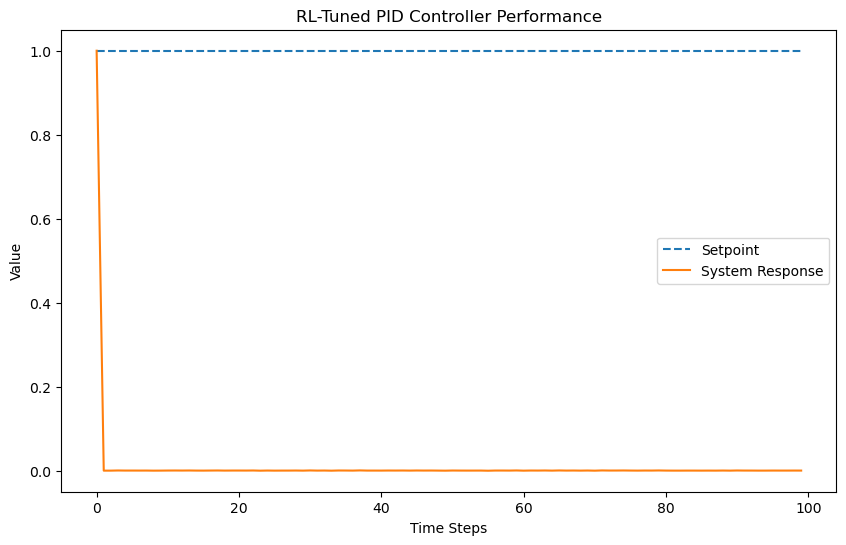

In [27]:

# Create and check the environment
env = PIDTuningEnv()
# n_env = env
check_env(env)  # This will check if the environment is correctly set up


# Specify 'cuda' to use the GPU
model = PPO('MlpPolicy', env, verbose=1, device='cuda')
# model = PPO('MlpPolicy', env, verbose=1, batch_size=4096, learning_rate=0.0005, n_steps=1024, device='cuda')
# model = PPO('MlpPolicy', env, verbose=1, learning_rate=3e-4, batch_size=128, n_steps=2048, 
            # clip_range=0.2, vf_coef=0.5, ent_coef=0.01, device='cuda')

# Train the PPO model
model.learn(total_timesteps=100000)  # You can adjust the timesteps as needed

# Save the trained model
model.save("ppo_pid_tuning")

# To load the model later, you can use:
# model = PPO.load("ppo_pid_tuning")

# Evaluate the trained model
obs, info = env.reset()
time_steps = []
setpoints = []
responses = []

for t in range(100):
    action, _states = model.predict(obs)
    obs, rewards, terminated, truncated, info = env.step(action)
    
    time_steps.append(t)
    setpoints.append(env.setpoint)
    responses.append(obs[0])  # Assuming the first element in obs is the current system output
    
    if terminated or truncated:
        break

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(time_steps, setpoints, label='Setpoint', linestyle='--')
plt.plot(time_steps, responses, label='System Response')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('RL-Tuned PID Controller Performance')
plt.legend()
plt.show()


Final PID constants - Kp: 2.4343042373657227, Ki: 2.6045002937316895, Kd: 3.375800848007202


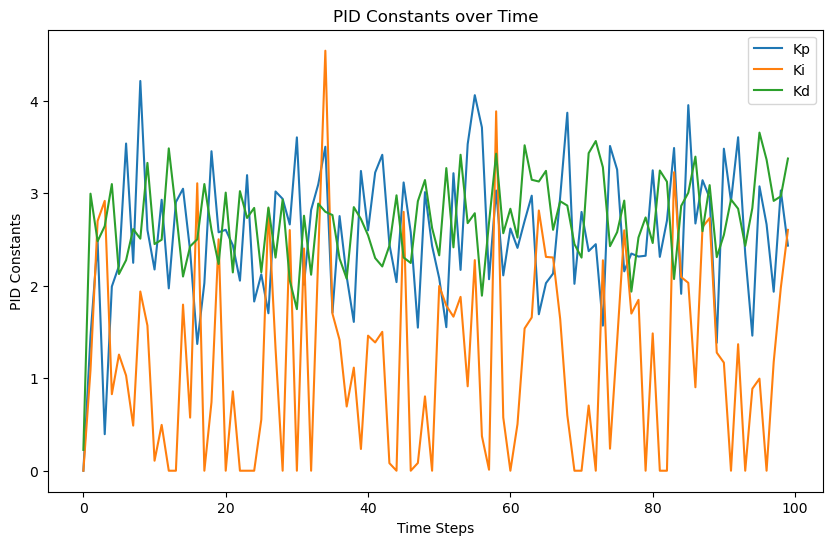

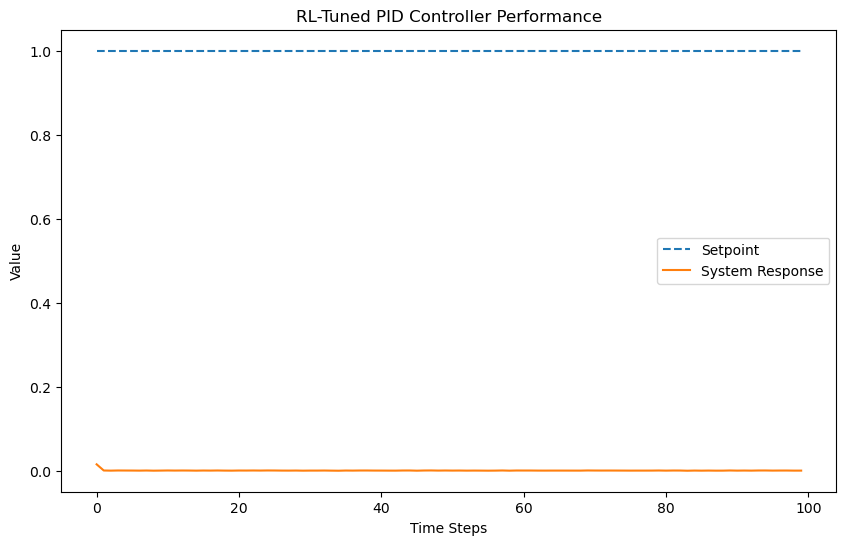

In [28]:
# Reset the environment
obs, info = env.reset()

# Lists to store time, setpoint, response, and PID constants for plotting
time_steps = []
setpoints = []
responses = []
Kp_values = []
Ki_values = []
Kd_values = []

# Run the trained agent
for t in range(100):
    # Predict the action (i.e., PID constants)
    action, _states = model.predict(obs)
    
    # Extract the PID constants
    Kp, Ki, Kd = action
    
    # Store the PID constants
    Kp_values.append(Kp)
    Ki_values.append(Ki)
    Kd_values.append(Kd)
    
    # Step through the environment
    obs, rewards, terminated, truncated, info = env.step(action)
    
    # Store time, setpoint, and response
    time_steps.append(t)
    setpoints.append(env.setpoint)
    responses.append(obs[0])  # Assuming the first element in obs is the current system output
    
    if terminated or truncated:
        break

# Print the final PID constants
# print(f"Final PID constants - Kp: {Kp}, Ki: {Ki}, Kd: {Kd}")
print(f"Final PID constants - Kp: {env.Kp}, Ki: {env.Ki}, Kd: {env.Kd}")

# Plot the PID constants over time
plt.figure(figsize=(10, 6))
plt.plot(time_steps, Kp_values, label='Kp')
plt.plot(time_steps, Ki_values, label='Ki')
plt.plot(time_steps, Kd_values, label='Kd')
plt.xlabel('Time Steps')
plt.ylabel('PID Constants')
plt.title('PID Constants over Time')
plt.legend()
plt.show()

# Plot the system's response
plt.figure(figsize=(10, 6))
plt.plot(time_steps, setpoints, label='Setpoint', linestyle='--')
plt.plot(time_steps, responses, label='System Response')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('RL-Tuned PID Controller Performance')
plt.legend()
plt.show()
